In [7]:
import sys
path_to_src_dir = '/home/penguin/projects/perovskite_analyzer/src'
if path_to_src_dir not in sys.path:
    sys.path.append(path_to_src_dir)
import matplotlib.pyplot as plt
from pyrovskite.perovskite import Perovskite as pk
# import nglview as nv # Comment if you don't have nglview, and don't run the next block.
import numpy as np
import ase.io

## Introduction to the Perovskite class

First let's load in a perovskite system into an ASE Atoms object and visualize it so that we know what to expect from the analysis tool.

If you have nglview installed, you'll see that we're looking at a 2DRP perovskite from the builder module. If not, just move on to the next cell.

*Note the nearly overlapping hydrogen atoms*, be sure to consult The_builder_module notebook for how to avoid this!

In [2]:
atoms = ase.io.read("../tests/data/test_rp.json")
view = nv.show_ase(atoms)
view.add_unitcell()
view

NGLWidget()

## Using the Perovskite class.

Now we have two options of loading information into the Perovskite class (the fundamental data type of the package). It can be simply passed in as a filename, or as an ASE Atoms object. Additional information can be passed in, such as the identity of the A, B, X, Ap, Bp building components... If these are not passed in as kwargs, then the code will aim to identify the B, X buidling components (and the Bp building component in the case of a double perovskite).

If no info is passed, the code will let you know what it identified as your B- (if applicable Bp-) and X-ions.

In [3]:
# Option one passing a file name.
perov1 = pk("../tests/data/mapbi3.cif")

print("==================================")

# Option two passing an Atoms object.
atoms = ase.io.read("../tests/data/mapbi3.cif")
perov2 = pk(atoms)


No B-cation set, candidate B-cations determined from structure:
['Pb']


No X-anion set, candidate X-anions determined from structure:
['I']


No B-cation set, candidate B-cations determined from structure:
['Pb']


No X-anion set, candidate X-anions determined from structure:
['I']



#### A, and Ap cations are really just settable for convience of data processing (e.g. export of the Perovskite objects to rows of a pandas DataFrame), but are not currently used for computing anything in the code base. 
------
## The ion detection system..
 
 It's worth noting that the code's identification system for the BX building components is relatively robust. It will detect:
 - BX components of ABX$_3$ type perovskites
 - BX components of 2D perovskites 
 - Double perovksite systems, setting the B and Bp cations accordingly (in arbitrary order)
 - 2D Double perovskite systems, setting the B and Bp cations accordingly
 - **X-anions even in the case that organic molecules in the system contain similar atoms (e.g. organic spacers containing e.g. Cl, F, O anions will not be mistaken for halogens in the BX subsystem). See example below.**
 - - This feature suits the library well to deal with hybrid perovksite and 2D perovskite systems.
 - - Implementation of this method aims to judge, based on the local chemical environment of X-ion candidates, whether they are part of an organic subsystem, or the inorganic subsystem. See the Perovskite constructor for more on how this process is carried out.
 
 Now with B and X building components established, we can identify the BX$_6$ octahedra in our perovskite system.

 We'll swap to a system with more than a single octahedra so that the format will be more clear.

 The output of ```Perovskite.identify_octahedra()``` will be an array of shape:
 
 
 (N_octa, 7, 3), corresponding to:
 
  \# of octahedra, 1 B-cation + 6 X-anions, 3 cartesian coordinates


In [4]:
perov3 = pk("../tests/data/599.cif")
perov3.identify_octahedra()
print(f"\nOutput array shape:\n {perov3.octahedra.shape}")


No B-cation set, candidate B-cations determined from structure:
['Pb']


No X-anion set, candidate X-anions determined from structure:
['Cl', 'I']

I detected as the X-anion. [From local env.]

Output array shape:
 (4, 7, 3)


### We can now visualize these octahedra if desired...
- Note that the colorations of the B-X bonds will match for what the code determines to be the three trans-X-B-X components.
- - This is important for the $\Sigma$ descriptor as trans-angles need to be excluded.
- - This is important for the  $\Lambda_3/\Lambda_2$ descriptor as trans X-X lines define the octahedral basis.

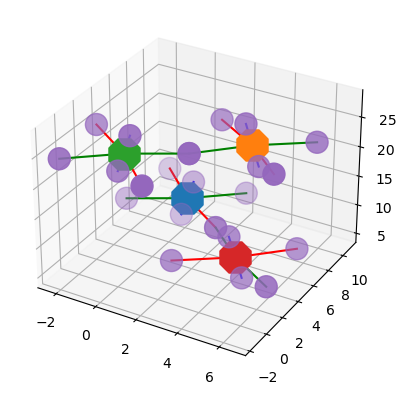

In [6]:
perov3.plot_vertices()

####  The final tool we'll show for this basic usage example is the computation of the $\Delta$ and $\Sigma$ octahedral distortion parameters.

These are given by the formula:

$$\Delta = \frac{1}{6}\Sigma_i (\frac{d_i - d_{avg}}{d_{avg}})^2$$
It's could be desirable to simply take the square root of $\Delta$ so that the quantity has a more direct physical interpretation though.

and 

$$\Sigma = \frac{1}{12}\Sigma_{cis} |\theta_{cis}-90|$$

Briefly worth noting, there are 15 unique X-B-X angles in the BX$_6$ octahedra... The 3 trans-angles and 12-cis angles are differentiated from one another in the ```Perovskite.compute_sigma()``` function, __visit there to see implementation details if desired.__

Both the ```Perovskite.compute_sigma()``` and ```Perovskite.compute_delta()``` functions have the option to return:

1) The average quantity over all octahedra, 
2) The quantity for each octahedra, or 
3) Both average, and octahedra specific quantities... 

Specify this with ```return_type = ```
1) ```'sigma'/'delta'```, 
2) ```'octahedra_sigma'/'octahedra_delta'```, or 
3) ```'both'```


Also let's swap to an example using a double perovskite system to demonstrate that both the **Sb** and **In** cations are correctly detected and placed into the B, Bp building components.

In [7]:
perov4 = pk("../tests/data/3AMP_CsInSbI_dj.cif")


No B-cation set, candidate B-cations determined from structure:
['Sb', 'In']

Two B-site candidates found, possible double perovskite system
Setting B=Sb and Bp=In

No X-anion set, candidate X-anions determined from structure:
['I']



In [8]:
sigma, octahedra_sigma = perov4.compute_sigma(return_type = 'both')
print(F"Sigma:{sigma}")
print(F"Sigma for each octahedra:{octahedra_sigma}")

Sigma:3.1056874220863913
Sigma for each octahedra:[3.99967035 1.68098048 2.14586783 4.59623103]


In [10]:
delta, octahedra_delta = perov4.compute_delta(return_type = 'both')
print(F"Delta:{delta}")
print(F"sqrt(Delta):{np.sqrt(delta)}")
print(F"Delta for each octahedra:{octahedra_delta}")

Delta:0.00034644998540341607
sqrt(Delta):0.018613166990155545
Delta for each octahedra:[4.63862260e-04 2.44981753e-04 6.07915749e-04 6.90401800e-05]


## This concludes the basic usage of the code. 
## For additional information see the other notebooks:

#### The_builder_module.ipynb
- How to create bulk, 2d, double, 2d-double perovskites of numerous phases.

#### Perovskite_geometry.ipynb
- Options for the in-built rdf function.
- Options for the in-built bond angles function.
- Options for the in-built bond distance function.

#### The_Lambda_parameters.ipynb
- Descritption/derivation of the Lambda descriptors as described in (add DOI)
- How to compute the Lambda descriptor using the code.